# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import os
import nltk
import tensorflow as tf
from keras.layers import *
from tensorflow import *
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import *
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
import csv
import random
from collections import Counter
from utils.textnormalization import TextNormalization
from utils.machinelearning import machine_learning_model, fit_model, metrics_values, confusion_matrix_
from utils.deeplearning import convolutional_neural_network_1d, model_compile, model_fit, evaluate, plot_accuracy_loss, lstm_, gru_
from utils.sentimentinformation import sentiment_percentage, sentiment_counts
from utils.wordcloud import wordcloud
from utils.most_frequent_word_plot import go_figure, bar_plot
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
import arabic_reshaper
from bidi.algorithm import get_display
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

# Download Some Packages

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [4]:
df1 = pd.read_csv('dev.csv')
df2 = pd.read_csv('train.csv')
df3 = pd.read_csv('test.csv')
Corpus = pd.concat([df1, df2, df3], ignore_index=True)
Corpus.drop('clean_txt', inplace=True, axis=1)
Corpus.rename(columns={'sentiment': 'Sentiment', 'txt': 'Review'}, inplace=True)
Corpus.tail(5)

,Sentiment,Review
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً..."
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...
16438,Negative,خذلتنى هذه الرواية كثيرا لم يعجبنى ابدا تداخل...


# Sentiment Information

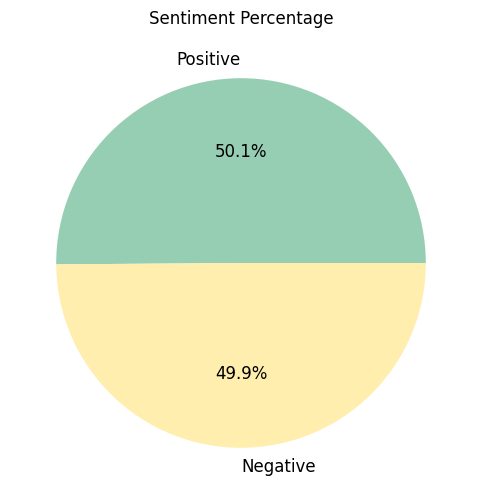

In [5]:
sentiment_percentage(Corpus, 'Sentiment', (6, 6))

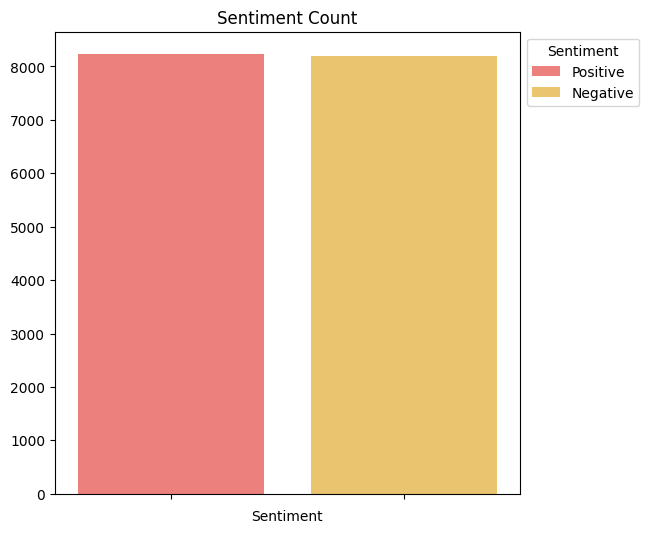

In [6]:
sentiment_counts(Corpus, 'Sentiment', (6, 6))

# Number Of Sentences

In [7]:
Corpus['NumberOfSentences'] = Corpus['Review'].apply(lambda n:len(sent_tokenize(n)))
Corpus.drop(Corpus[Corpus["NumberOfSentences"] == 0].index, inplace = True)


In [8]:
Corpus['NumberOfSentences'].sum()

48524

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

326

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Text Normalization

In [12]:
text_normalization = TextNormalization(_remove_emojis = True,
                                        _remove_hashtags = False,
                                        _remove_emails = False ,
                                        _remove_url = False,
                                        _remove_mention = False,
                                        _remove_duplicate_char = True,
                                        _remove_single_char = True,
                                        _remove_special_character_ = True,
                                        _remove_new_line_char = True,
                                        _remove_number = True,
                                        _remove_html_tags = True,
                                        _remove_arabic_diacritics_ = True,
                                        _normalize_arabic_unicode_ = True,
                                        _normalize_alef_maksura_ar_ = True,
                                        _normalize_alef_ar_ = True,
                                        _normalize_teh_marbuta_ar_ = True,
                                        _remove_non_arabic = True,
                                        _remove_whitespace_ = True,
                                        _remove_unicode_characters_ = True,
                                        _remove_longest_than_ = True,
                                        _remove_stop_words = True,
                                        _lemmatizer_ = False,
                                        _stemmer_ = False)

In [13]:
Corpus['Normalized_Review'] = Corpus['Review'].apply(lambda x: text_normalization.normalization(x))
Corpus.tail(5)

,Sentiment,Review,NumberOfSentences,Normalized_Review
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...,1,الشفقه العطف اقيم الروايه يؤسفني معاناه محمد ش...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً...",3,اوصيك بالدقه بالوضوح فاليري ابراهيم اصلان نفذ ...
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...,2,للاسف الشديد يعجبني الكتاب شعرت بالملل الصفحات...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...,14,بدايه الروايه وانا احاول تمالك تعاندني عبرات م...
16438,Negative,خذلتنى هذه الرواية كثيرا لم يعجبنى ابدا تداخل...,1,خذلتني الروايه يعجبني ابدا تداخل قصتي الكاتب و...


# Number Of Unique Words

In [14]:
UniqueWords = set()
for word in Corpus['Normalized_Review'].str.split():
    UniqueWords.update(word)

len(UniqueWords)

74034

# WordCloud

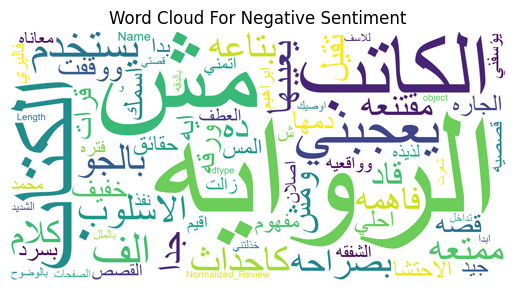

In [15]:
wordcloud(data=Corpus, target='Negative', width=2000, hieght=1000, text='Normalized_Review')

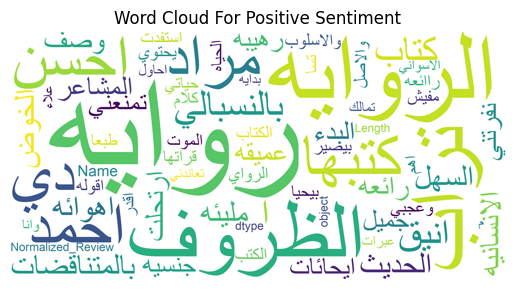

In [16]:
wordcloud(data=Corpus, target='Positive', width=2000, hieght=1000, text='Normalized_Review')

# Most Frequent Words 

In [17]:
MostFrequentWord = Counter((Corpus['Normalized_Review']).str.split().explode()).most_common(15)
MostFrequentWordDF = pd.DataFrame(MostFrequentWord, columns=('Word', 'Count'))
MostFrequentWordDF

,Word,Count
0,الروايه,7347
1,الكتاب,6617
2,كتاب,3828
3,روايه,3154
4,الكاتب,2793
5,الله,2312
6,اللي,1878
7,مش,1444
8,رائع,1431
9,الاحداث,1247


In [18]:
go_figure(data=MostFrequentWordDF)

In [19]:
bar_plot(data=MostFrequentWordDF)

# Number Of Words 

In [20]:
Corpus["Number of Words"] = Corpus["Normalized_Review"].apply(lambda n:len(word_tokenize(n)))
Corpus.drop(Corpus[ Corpus["Number of Words"] == 0].index, inplace = True)
Corpus["Number of Words"].sum()

569184

# Number Of Charachters 

In [21]:
Corpus["Number of Charachters"] = Corpus["Normalized_Review"].str.len()
Corpus["Number of Charachters"].sum()

3543446

# Average Number Of Words 

In [22]:
AverageNaumberOfWords = int(np.round((Corpus["Number of Words"].mean())))
AverageNaumberOfWords

35

# Average Number Of Charachters 

In [23]:
AverageNumberOfCharachters = int(np.round(Corpus["Number of Charachters"].mean()))
AverageNumberOfCharachters

216

# Maximum Number Of Word

In [24]:
MaximumNaumberOfWords = Corpus["Number of Words"].max()
MaximumNaumberOfWords

1853

# Maximum Number Of Charachters 

In [25]:
MaximumNumberOfCharachters = Corpus['Number of Charachters'].max() 
MaximumNumberOfCharachters

11593

# Minimum Number Of Words

In [26]:
MimimumNaumberOfWords = Corpus["Number of Words"].min()
MimimumNaumberOfWords

1

# Minimum Number Of Charachters 

In [27]:
MinimumNumberOfCharachters = Corpus['Number of Charachters'].min() 
MinimumNumberOfCharachters

3

# Split The Dataset Into X And y

In [28]:
X, y = Corpus['Normalized_Review'], Corpus['Sentiment']
le = LabelEncoder()
y =le.fit_transform(y)

# Split The Dataset Into Training And Testing

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

# CountVectorizer

In [30]:
CountVectorizer_ = CountVectorizer()
X_train_CV_ = CountVectorizer_.fit_transform(X_train)
X_test_CV_ = CountVectorizer_.transform(X_test)

In [31]:
Vocabulary = CountVectorizer_.vocabulary_
Vocabulary

{'سيناريو': 30772,
 'فيلم': 35960,
 'عربي': 33000,
 'ساذج': 29583,
 'فشل': 35146,
 'روايه': 29154,
 'مثيره': 44379,
 'استمتعت': 2533,
 'جيد': 26175,
 'قراءه': 36337,
 'الروايه': 8265,
 'اكره': 4350,
 'البطل': 5895,
 'جاء': 25442,
 'التقييم': 6584,
 'درااما': 27927,
 'ملهاش': 46924,
 'اي': 15373,
 'لازمه': 38398,
 'تعجبني': 23588,
 'ابدا': 141,
 'كتبت': 37242,
 'طريقه': 32284,
 'الخواطر': 7732,
 'غازي': 33689,
 'القصيبي': 10712,
 'اجتر': 790,
 'طوال': 32387,
 'القصه': 10707,
 'مليئه': 46950,
 'بالمعاناه': 17159,
 'والماساه': 52883,
 'يوجد': 63935,
 'احداث': 1084,
 'تشد': 23064,
 'انتباه': 14482,
 'القارئ': 10538,
 'مجرد': 44459,
 'مذكرات': 45036,
 'لمصاب': 42171,
 'بالزهايمر': 16623,
 'اسوا': 2803,
 'قرات': 36356,
 'لغازي': 40318,
 'الاسف': 4934,
 'حاولت': 26331,
 'اتحشي': 365,
 'الكتاب': 10896,
 'لشعوري': 40046,
 'بسيط': 18907,
 'اضطررت': 3185,
 'لقراءته': 40489,
 'بناء': 20167,
 'طلب': 32345,
 'البوك': 6003,
 'كلاب': 37666,
 'اللي': 11234,
 'مشتركه': 45690,
 'كتاب': 37209,
 'خفيف': 27

# Machine Learning

**1-Naive Bayes**

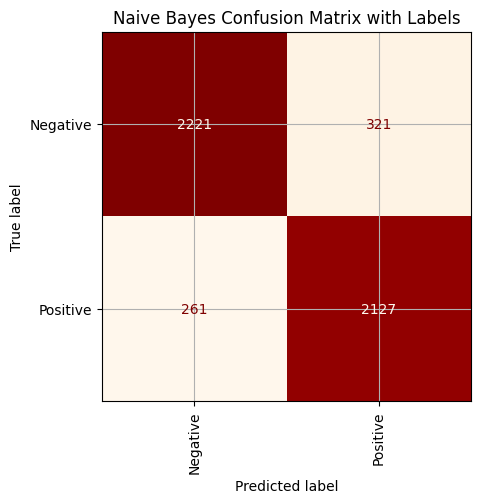

In [32]:
Algorithm = MultinomialNB(alpha= 1)
Naive_Bayes = machine_learning_model(algorithm=Algorithm)
fit_model(model=Naive_Bayes, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Naive_Bayes, X_test=X_test_CV_, y_test=y_test, name='Naive Bayes')

In [33]:
metrics_values(model= Naive_Bayes, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.881947
Precision,0.890704
Recall,0.868873
F1Score,0.879653
Error,0.118053


**2-Logistic Regression**

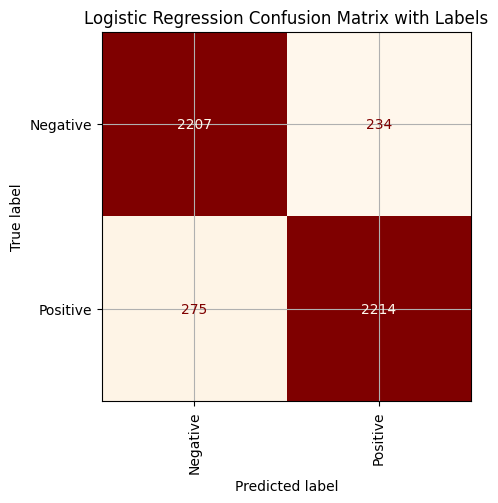

In [34]:
Algorithm = LogisticRegression()
Logistic_Regression = machine_learning_model(algorithm=Algorithm)
fit_model(model=Logistic_Regression, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(Logistic_Regression, X_test=X_test_CV_, y_test=y_test, name='Logistic Regression')

In [35]:
metrics_values(model= Logistic_Regression, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.896755
Precision,0.889514
Recall,0.904412
F1Score,0.896901
Error,0.103245


**3-Decision Tree**

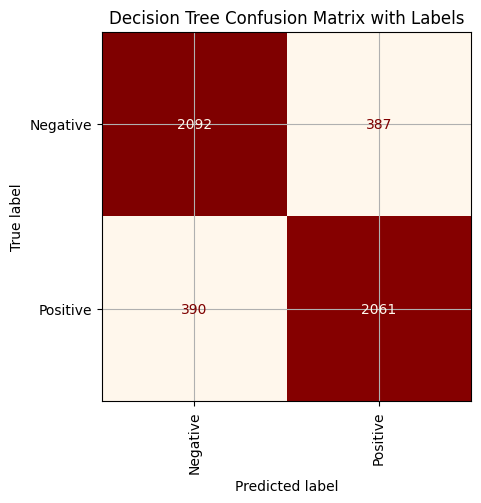

In [36]:
Algorithm = DecisionTreeClassifier(criterion='entropy')
Decision_Tree = machine_learning_model(algorithm=Algorithm)
fit_model(model=Decision_Tree, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Decision_Tree, X_test=X_test_CV_, y_test=y_test, name='Decision Tree')

In [37]:
metrics_values(model= Decision_Tree, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.842394
Precision,0.840881
Recall,0.841912
F1Score,0.841396
Error,0.157606


**4-K Nearest Neighbors**

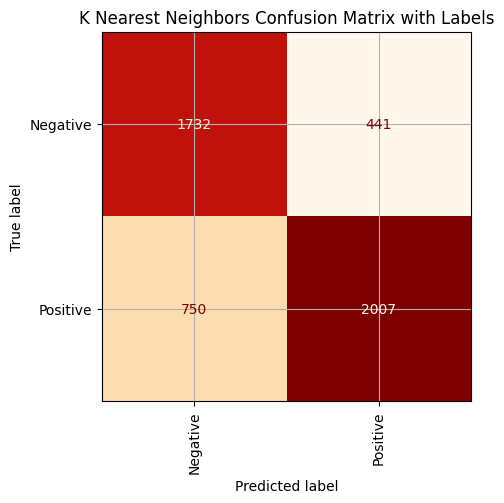

In [38]:
Algorithm =KNeighborsClassifier(metric='cosine', n_neighbors=5)
K_Nearest_Neighbors = machine_learning_model(algorithm=Algorithm)
fit_model(model=K_Nearest_Neighbors, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=K_Nearest_Neighbors, X_test=X_test_CV_, y_test=y_test, name='K Nearest Neighbors')

In [39]:
metrics_values(model= K_Nearest_Neighbors, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.758418
Precision,0.727965
Recall,0.819853
F1Score,0.771182
Error,0.241582


**5-Random Forest**

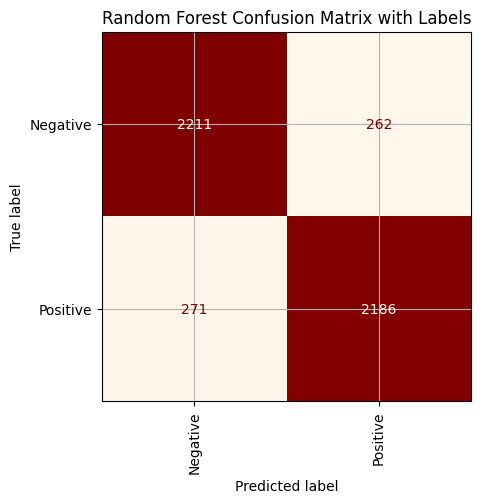

In [40]:
Algorithm = RandomForestClassifier(criterion = 'entropy', n_estimators=100)
Random_Forest = machine_learning_model(algorithm=Algorithm)
fit_model(model=Random_Forest, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=Random_Forest, X_test=X_test_CV_, y_test=y_test, name='Random Forest')

In [41]:
metrics_values(model= Random_Forest, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.891886
Precision,0.889703
Recall,0.892974
F1Score,0.891335
Error,0.108114


**6-SGD Classifier**

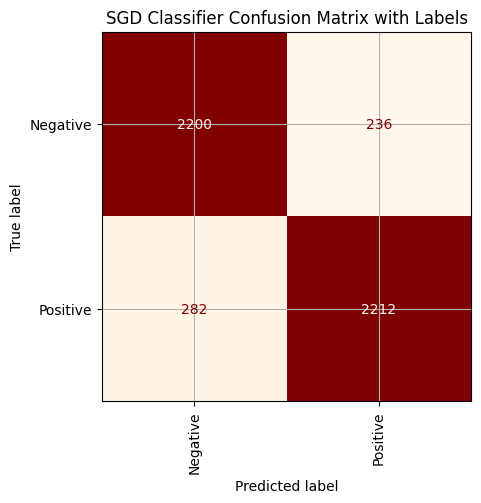

In [42]:
Algorithm = SGDClassifier(loss='hinge')
SGD = machine_learning_model(algorithm=Algorithm)
fit_model(model=SGD, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=SGD, X_test=X_test_CV_, y_test=y_test, name='SGD Classifier')

In [43]:
metrics_values(model= SGD, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.894929
Precision,0.886929
Recall,0.903595
F1Score,0.895184
Error,0.105071


**7-Multilayer Perceptron**

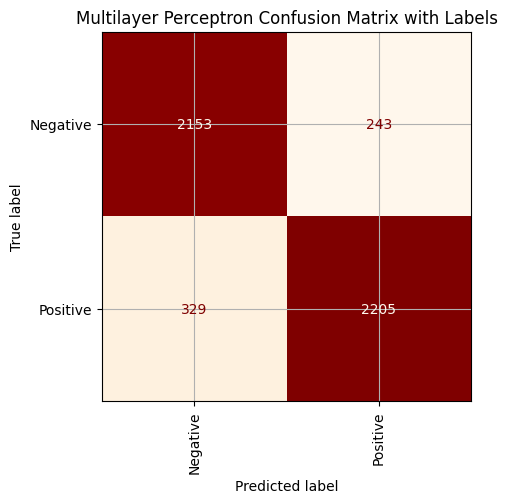

In [44]:
Algorithm = MLPClassifier(hidden_layer_sizes=16)
MLP = machine_learning_model(algorithm=Algorithm)
fit_model(model=MLP, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=MLP, X_test=X_test_CV_, y_test=y_test, name='Multilayer Perceptron')

In [45]:
metrics_values(model= MLP, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.883976
Precision,0.870166
Recall,0.900735
F1Score,0.885187
Error,0.116024


**8-Support Vector Machine**

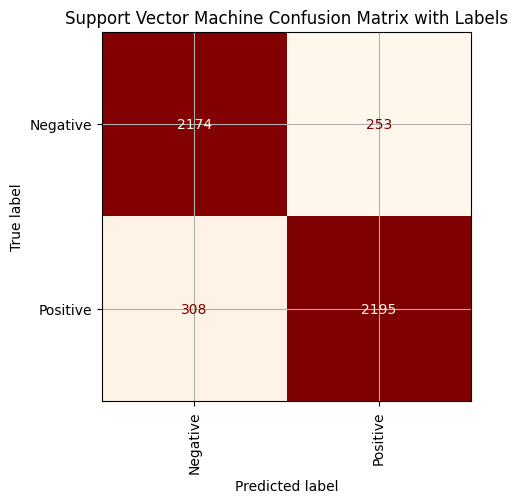

In [46]:
Algorithm = SVC(kernel='linear')
SVM = machine_learning_model(algorithm=Algorithm)
fit_model(model=SVM, X_train=X_train_CV_, y_train=y_train)
confusion_matrix_(model=SVM, X_test=X_test_CV_, y_test=y_test, name='Support Vector Machine')

In [47]:
metrics_values(model= SVM, X_test=X_test_CV_, y_test=y_test)

,Values
Accuracy,0.886207
Precision,0.876948
Recall,0.896650
F1Score,0.886690
Error,0.113793


# Deep Learning

In [48]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(X_train)
embedding_dim = 16
vocab_size = len(tokenizer.word_index) + 1
vocab_size

64050

In [49]:
X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_test_seqs = tokenizer.texts_to_sequences(X_test)
max_length =  max([len(x) for x in X_train_seqs])
max_length

1853

In [50]:
encoded_X_train = pad_sequences(X_train_seqs, maxlen=max_length, truncating='pre', padding='pre')
encoded_X_test = pad_sequences(X_test_seqs, maxlen=max_length, truncating='pre', padding='pre')

In [51]:
Callback = tf.keras.callbacks.EarlyStopping(
                    monitor="accuracy",
                    mode="max",
                    patience=3
                )

**9-Convolutional Neural Network**

Epoch 1/15
719/719 [==============================] - 159s 216ms/step - loss: 0.6907 - accuracy: 0.5367 - val_loss: 0.6811 - val_accuracy: 0.5941
Epoch 2/15
719/719 [==============================] - 150s 209ms/step - loss: 0.6359 - accuracy: 0.6925 - val_loss: 0.6100 - val_accuracy: 0.7272
Epoch 3/15
719/719 [==============================] - 127s 177ms/step - loss: 0.5056 - accuracy: 0.8003 - val_loss: 0.4856 - val_accuracy: 0.7714
Epoch 4/15
719/719 [==============================] - 125s 174ms/step - loss: 0.3770 - accuracy: 0.8568 - val_loss: 0.4096 - val_accuracy: 0.7963
Epoch 5/15
719/719 [==============================] - 107s 149ms/step - loss: 0.3051 - accuracy: 0.8858 - val_loss: 0.3663 - val_accuracy: 0.8233
Epoch 6/15
719/719 [==============================] - 88s 122ms/step - loss: 0.2505 - accuracy: 0.9062 - val_loss: 0.3578 - val_accuracy: 0.8229
Epoch 7/15
719/719 [==============================] - 76s 105ms/step - loss: 0.2162 - accuracy: 0.9192 - val_loss: 0.3457 - v

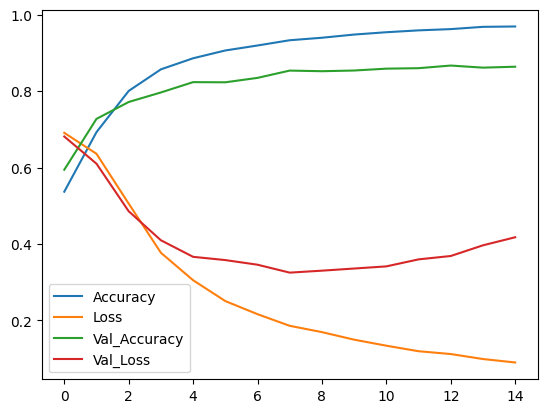

 
The Training Loss is 0.0683, And Training Accuracy is 0.9709
 
The Testing Loss is 0.4175, And Testing Accuracy is 0.8637


In [52]:
convolutional_neural_network = convolutional_neural_network_1d(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length, dropout=0.8, kernel=8, filters=32)
model_compile(model=convolutional_neural_network)
history = model_fit(model=convolutional_neural_network, X_train=encoded_X_train, y_train=y_train, epochs=15, X_test=encoded_X_test, y_test=y_test, batch_size=16, Callback=Callback, shuffle=True)
plot_accuracy_loss(histoty=history)
evaluate(model=convolutional_neural_network, x=encoded_X_train, y=y_train, train_test='Training')
evaluate(model=convolutional_neural_network, x=encoded_X_test, y=y_test, train_test='Testing')

**10-LSTM**

Epoch 1/5
360/360 [==============================] - 130s 335ms/step - loss: 0.5247 - accuracy: 0.7318 - val_loss: 0.3561 - val_accuracy: 0.8398
Epoch 2/5
360/360 [==============================] - 101s 281ms/step - loss: 0.1618 - accuracy: 0.9423 - val_loss: 0.3138 - val_accuracy: 0.8830
Epoch 3/5
360/360 [==============================] - 104s 290ms/step - loss: 0.0529 - accuracy: 0.9844 - val_loss: 0.3841 - val_accuracy: 0.8830
Epoch 4/5
360/360 [==============================] - 111s 308ms/step - loss: 0.0284 - accuracy: 0.9910 - val_loss: 0.4571 - val_accuracy: 0.8728
Epoch 5/5
360/360 [==============================] - 104s 290ms/step - loss: 0.1686 - accuracy: 0.9535 - val_loss: 0.4344 - val_accuracy: 0.8361


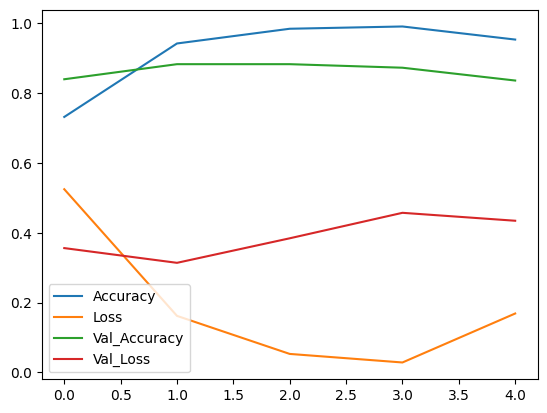

 
The Training Loss is 0.0974, And Training Accuracy is 0.9690
 
The Testing Loss is 0.4344, And Testing Accuracy is 0.8361


In [53]:

LSTM =lstm_(vocab_size= vocab_size, embedding_dim= embedding_dim, max_length= max_length, dropout=0.2, units=64)
model_compile(model=LSTM)
history = model_fit(model=LSTM, X_train=encoded_X_train, y_train=y_train, epochs=5, X_test=encoded_X_test, y_test=y_test, batch_size=32, Callback=Callback, shuffle=True)
plot_accuracy_loss(histoty=history)
evaluate(model=LSTM, x=encoded_X_train, y=y_train, train_test='Training')
evaluate(model=LSTM, x=encoded_X_test,y= y_test, train_test='Testing')

**11-GRU**

Epoch 1/5
360/360 [==============================] - 153s 403ms/step - loss: 0.5070 - accuracy: 0.7332 - val_loss: 0.3304 - val_accuracy: 0.8550
Epoch 2/5
360/360 [==============================] - 134s 373ms/step - loss: 0.1395 - accuracy: 0.9505 - val_loss: 0.3247 - val_accuracy: 0.8886
Epoch 3/5
360/360 [==============================] - 115s 318ms/step - loss: 0.0446 - accuracy: 0.9860 - val_loss: 0.3924 - val_accuracy: 0.8892
Epoch 4/5
360/360 [==============================] - 106s 293ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.4716 - val_accuracy: 0.8858
Epoch 5/5
360/360 [==============================] - 91s 254ms/step - loss: 0.0122 - accuracy: 0.9966 - val_loss: 0.5839 - val_accuracy: 0.8890


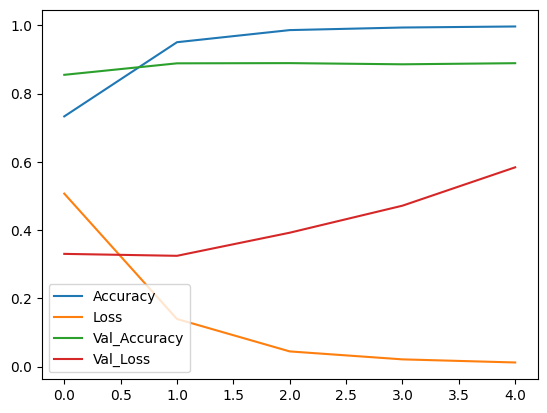

 
The Training Loss is 0.0078, And Training Accuracy is 0.9974
 
The Testing Loss is 0.5839, And Testing Accuracy is 0.8890


In [54]:
GRU_=gru_(vocab_size= vocab_size, embedding_dim= embedding_dim, max_length= max_length, dropout=0.3, units=32)
model_compile(model=GRU_)
history = model_fit(model=GRU_, X_train=encoded_X_train, y_train=y_train, epochs=5, X_test=encoded_X_test, y_test=y_test, batch_size=32, Callback=Callback, shuffle=True)
plot_accuracy_loss(histoty=history)
evaluate(model=GRU_, x=encoded_X_train, y=y_train, train_test='Training')
evaluate(model=GRU_, x=encoded_X_test,y= y_test, train_test='Testing')